<h2>데이터를 Dataframe으로 열어 데이터를 확인한다.</h2>
 
- u.item: item 정보를 담은 데이터
- u.info: 데이터셋의 통계 정보를 담은 데이터
- u1.base: 추천 시스템의 학습 데이터
- u1.test: 추천 시스템의 평가 데이터
  

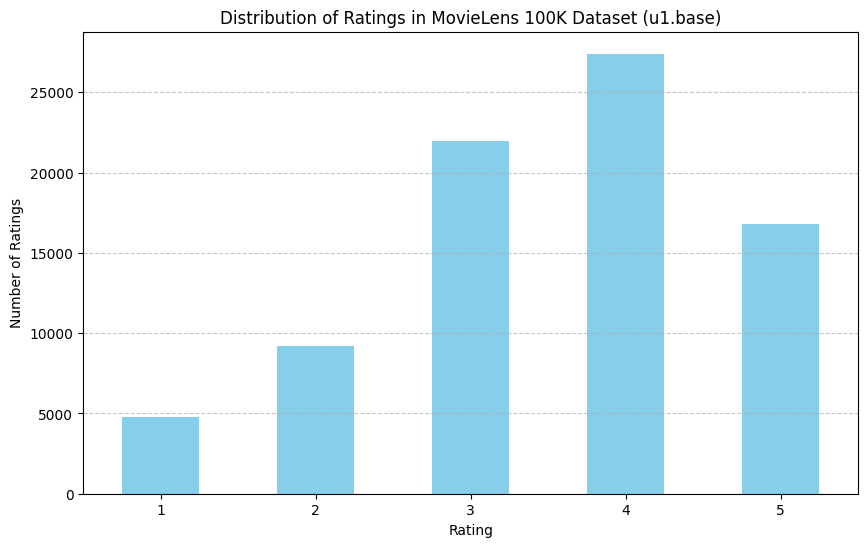

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# u1.base 파일 경로를 지정
file_path = 'ml-100k/u1.base'

# 데이터를 불러오기
column_names = ['user_id', 'item_id', 'rating', 'timestamp']
data = pd.read_csv(file_path, sep='\t', names=column_names)

# 별점 분포를 시각화
plt.figure(figsize=(10, 6))
data['rating'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Distribution of Ratings in MovieLens 100K Dataset (u1.base)')
plt.xlabel('Rating')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig("u1.base dist.png")
plt.show()

In [2]:
# u.item 파일 경로를 지정
file_path = 'ml-100k/u.item'

# 데이터를 불러오기
column_names = ['movie_id', 'movie_title', 'release_date', 'video_release_date', 'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
df = pd.read_csv(file_path, sep='|', names=column_names, encoding='latin-1')
# 필요한 열만 선택
selected_columns = df[['movie_id', 'movie_title', 'release_date']]

In [3]:
# 장르가 액션인 영화만 필터링
action_movies = selected_columns[df['Horror'] == 1]
# 액션 영화 데이터프레임 출력
print(action_movies.head(8))  # 첫 8개 행 확인

animation_movies = selected_columns[df['Thriller'] == 1]
print(animation_movies.head(8))  # 첫 8개 행 확인

     movie_id                                     movie_title release_date
16         17                      From Dusk Till Dawn (1996)  05-Feb-1996
83         84  Robert A. Heinlein's The Puppet Masters (1994)  01-Jan-1994
100       101                              Heavy Metal (1981)  08-Mar-1981
122       123                         Frighteners, The (1996)  19-Jul-1996
182       183                                    Alien (1979)  01-Jan-1979
183       184                         Army of Darkness (1993)  01-Jan-1993
184       185                                   Psycho (1960)  01-Jan-1960
199       200                             Shining, The (1980)  01-Jan-1980
    movie_id                    movie_title release_date
1          2               GoldenEye (1995)  01-Jan-1995
2          3              Four Rooms (1995)  01-Jan-1995
4          5                 Copycat (1995)  01-Jan-1995
10        11           Seven (Se7en) (1995)  01-Jan-1995
11        12     Usual Suspects, The (19

<h2>Train the recommender systems and recommend top 10 movies</h2>

- 추천 알고리즘인 ALS 모델을 활용하여 추천 모델을 학습한다.
- 학습 후, 두 명의 유저 944와 945에게 상위 10개의 영화를 추천한다.


In [4]:
import pyspark
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Spark 세션 생성
spark = SparkSession.builder \
    .appName("MovieLens Recommendation System with CV") \
    .getOrCreate()

In [5]:
# 데이터 로드 
train = spark.read.csv("ml-100k/u1.base", header=None, inferSchema=True, sep="\t")
test = spark.read.csv("ml-100k/u1.test", header=None, inferSchema=True, sep="\t")

train = train.toDF("user_id", "movie_id", "rating", "timestamp")
test = test.toDF("user_id", "movie_id", "rating", "timestamp")

# 데이터의 첫 몇 행 확인
train.show(5)

+-------+--------+------+---------+
|user_id|movie_id|rating|timestamp|
+-------+--------+------+---------+
|      1|       1|     5|874965758|
|      1|       2|     3|876893171|
|      1|       3|     4|878542960|
|      1|       4|     3|876893119|
|      1|       5|     3|889751712|
+-------+--------+------+---------+
only showing top 5 rows



In [6]:
# spark to pandas 
pandas_df = train.select('*').toPandas()
display(pandas_df)

,user_id,movie_id,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712
...,...,...,...,...
80054,945,110,1,888640290
80055,945,177,1,888640271
80056,945,203,1,888640290
80057,945,232,1,888640275


In [7]:
# u.item 파일 경로를 지정
file_path = 'ml-100k/u.item'

# 데이터를 불러오기
column_names = ['movie_id', 'movie_title', 'release_date', 'video_release_date', 'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
df = pd.read_csv(file_path, sep='|', names=column_names, encoding='latin-1')

# 필요한 열만 선택
selected_columns = df[['movie_id', 'movie_title', 'release_date']]

# 액션 장르를 포함한 모든 영화 데이터프레임 저장
movies_df = df[['movie_id', 'movie_title', 'release_date', 'Action', 'Adventure', 'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']]

display(movies_df)

,movie_id,movie_title,release_date,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,Mat' i syn (1997),06-Feb-1998,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1678,1679,B. Monkey (1998),06-Feb-1998,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1679,1680,Sliding Doors (1998),01-Jan-1998,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1680,1681,You So Crazy (1994),01-Jan-1994,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
def get_genres(row):
    genres = []
    for genre in column_names[6:]:
        if row[genre] == 1:
            genres.append(genre)
    return ', '.join(genres)


<h5>user 944는 'Horror','Thriller' 영화에 높은 평점을,  'Children's', 'Musical'영화에 낮은 평점을 준 user이다.</h5>

    
<h5>user 945는 'Animation', 'Fantasy' 영화에 높은 평점을,  'War','Crime', 'Western'영화에 낮은 평점을 준 user이다.</h5>

In [9]:
print("User 944's ratings in train")
user944 = pandas_df[pandas_df['user_id'] == 944]
user944 = pd.merge(user944, movies_df, on='movie_id')
user944['genres'] = user944.apply(get_genres, axis=1)
# 필요 없는 장르 컬럼 삭제
user944 = user944[['movie_id', 'rating', 'movie_title', 'release_date', 'genres']]
display(user944)

User 944's ratings in train


,movie_id,rating,movie_title,release_date,genres
0,2,5,GoldenEye (1995),01-Jan-1995,"Action, Adventure, Thriller"
1,3,5,Four Rooms (1995),01-Jan-1995,Thriller
2,5,5,Copycat (1995),01-Jan-1995,"Crime, Drama, Thriller"
3,11,5,Seven (Se7en) (1995),01-Jan-1995,"Crime, Thriller"
4,12,5,"Usual Suspects, The (1995)",14-Aug-1995,"Crime, Thriller"
5,17,5,From Dusk Till Dawn (1996),05-Feb-1996,"Action, Comedy, Crime, Horror, Thriller"
6,23,5,Taxi Driver (1976),16-Feb-1996,"Drama, Thriller"
7,84,5,Robert A. Heinlein's The Puppet Masters (1994),01-Jan-1994,"Horror, Sci-Fi"
8,183,5,Alien (1979),01-Jan-1979,"Action, Horror, Sci-Fi, Thriller"
9,185,5,Psycho (1960),01-Jan-1960,"Horror, Romance, Thriller"


In [10]:
print("User 945's ratings in train")
user945 = pandas_df[pandas_df['user_id'] == 945]
user945 = pd.merge(user945, movies_df, on='movie_id')
user945['genres'] = user945.apply(get_genres, axis=1)
# 필요 없는 장르 컬럼 삭제
user945 = user945[['movie_id', 'rating', 'movie_title', 'release_date', 'genres']]
display(user945)

User 945's ratings in train


,movie_id,rating,movie_title,release_date,genres
0,1,5,Toy Story (1995),01-Jan-1995,"Animation, Children's, Comedy"
1,71,5,"Lion King, The (1994)",01-Jan-1994,"Animation, Children's, Musical"
2,72,5,"Mask, The (1994)",01-Jan-1994,"Comedy, Crime, Fantasy"
3,95,5,Aladdin (1992),01-Jan-1992,"Animation, Children's, Comedy, Musical"
4,99,5,Snow White and the Seven Dwarfs (1937),01-Jan-1937,"Animation, Children's, Musical"
5,101,5,Heavy Metal (1981),08-Mar-1981,"Action, Adventure, Animation, Horror, Sci-Fi"
6,102,5,"Aristocats, The (1970)",01-Jan-1970,"Animation, Children's"
7,103,5,All Dogs Go to Heaven 2 (1996),29-Mar-1996,"Animation, Children's, Musical"
8,114,5,Wallace & Gromit: The Best of Aardman Animatio...,05-Apr-1996,Animation
9,141,5,"20,000 Leagues Under the Sea (1954)",01-Jan-1954,"Adventure, Children's, Fantasy, Sci-Fi"


In [11]:
# ALS 모델 생성
als = ALS(
    userCol="user_id",
    itemCol="movie_id",
    ratingCol="rating",
    coldStartStrategy="drop"
)

# 파라미터 그리드 설정
paramGrid = ParamGridBuilder() \
    .addGrid(als.maxIter, [5, 10, 15]) \
    .addGrid(als.regParam, [0.01, 0.1, 0.5]) \
    .build()

In [12]:
# 평가기 설정
evaluator = RegressionEvaluator(
    metricName="rmse",
    labelCol="rating",
    predictionCol="prediction"
)

# 교차 검증기 설정
crossval = CrossValidator(
    estimator=als,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=5 # 5겹 교차 검증
)

In [13]:
# 교차 검증 모델 학습
cvModel = crossval.fit(train)

# 최적의 모델 선택
bestModel = cvModel.bestModel

In [14]:
# 최적 모델의 파라미터 출력
print(f"Best maxIter: {bestModel._java_obj.parent().getMaxIter()}")
print(f"Best regParam: {bestModel._java_obj.parent().getRegParam()}")

# 테스트 데이터에 대한 RMSE 평가
predictions = bestModel.transform(test)
rmse = evaluator.evaluate(predictions)
print(f"Root-mean-square error = {rmse}")

Best maxIter: 15
Best regParam: 0.1
Root-mean-square error = 0.9343061171005045


In [15]:
# 사용자에게 추천할 아이템 추출
userRecs = bestModel.recommendForAllUsers(10)
userRecs.show(5, truncate=False)

+-------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|user_id|recommendations                                                                                                                                                                      |
+-------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|1      |[{1449, 5.0798273}, {119, 4.76722}, {12, 4.7324915}, {50, 4.6987677}, {1467, 4.6828504}, {474, 4.678999}, {408, 4.6635237}, {89, 4.641549}, {1142, 4.6320844}, {169, 4.604025}]      |
|3      |[{1368, 5.077741}, {1643, 5.0538173}, {1558, 4.9440484}, {656, 4.8937273}, {589, 4.775065}, {1158, 4.773655}, {56, 4.7178097}, {1405, 4.7037663}, {1585, 4.6404037}, {192, 4.609063}]|
|5      |[{613, 4.7814813}, {1240, 4.776

In [16]:
display(userRecs.select('*').toPandas())

,user_id,recommendations
0,1,"[(1449, 5.079827308654785), (119, 4.7672200202..."
1,3,"[(1368, 5.0777411460876465), (1643, 5.05381727..."
2,5,"[(613, 4.7814812660217285), (1240, 4.776145458..."
3,6,"[(1643, 4.757741451263428), (1449, 4.436469554..."
4,9,"[(1643, 6.63769006729126), (954, 5.42902946472..."
...,...,...
940,940,"[(272, 4.212131023406982), (113, 4.20904350280..."
941,941,"[(1449, 5.078130722045898), (408, 4.9948377609..."
942,942,"[(1643, 5.175411701202393), (318, 4.9774637222..."
943,943,"[(1467, 4.830956935882568), (64, 4.67013692855..."


In [17]:
# 예시: 특정 사용자 ID (예: userId = 123)로 DataFrame 생성
userId = 123
user_subset = test.filter(test.user_id == userId).select("user_id").distinct()

# 해당 사용자에 대한 추천 추출
user_recs = bestModel.recommendForUserSubset(user_subset, 10)
user_recs.show(truncate=False)
display(user_recs.select('*').toPandas())

+-------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|user_id|recommendations                                                                                                                                                                   |
+-------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|123    |[{1512, 5.708774}, {1368, 5.48681}, {320, 5.111794}, {1449, 4.9608216}, {59, 4.8828526}, {1643, 4.8072357}, {512, 4.8035583}, {593, 4.796088}, {1642, 4.7874675}, {1021, 4.77042}]|
+-------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+



,user_id,recommendations
0,123,"[(1512, 5.708774089813232), (1368, 5.486810207..."


In [18]:
userId = 945
print(f'User {userId}\'s recommendation')
user_subset = train.filter(train.user_id == userId).select("user_id").distinct()

# 해당 사용자에 대한 추천 추출
user_recs = bestModel.recommendForUserSubset(user_subset, 10)
user_recs.show(truncate=False)

display(user_recs.select('*').toPandas())

User 945's recommendation
+-------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|user_id|recommendations                                                                                                                                                                 |
+-------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|945    |[{1233, 6.034416}, {1138, 5.828148}, {1609, 5.5313544}, {6, 5.514738}, {1066, 5.421926}, {1431, 5.30913}, {1643, 5.306767}, {261, 5.1834874}, {962, 5.166711}, {1147, 5.121228}]|
+-------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+



,user_id,recommendations
0,945,"[(1233, 6.034416198730469), (1138, 5.828147888..."


In [20]:
def print_recommendations(userId):
    print(f'User {userId}\'s recommendation')
    user_subset = train.filter(train.user_id == userId).select("user_id").distinct()

    # 해당 사용자에 대한 추천 추출
    user_recs = bestModel.recommendForUserSubset(user_subset, 10)
    # user_recs.show(truncate=False)
    df = user_recs.select('recommendations').toPandas()

    # recommendations 컬럼의 데이터를 확장
    expanded_rows = []
    for row in df.itertuples(index=False):
        expanded_rows.extend(row.recommendations)

    # 새로운 DataFrame 생성
    expanded_df = pd.DataFrame(expanded_rows, columns=['movie_id', 'rating'])

    # 영화 정보와 추천 결과 병합
    merged_df = pd.merge(expanded_df, movies_df, on='movie_id')

    # 장르 컬럼 이름을 합친 새로운 컬럼 추가
    merged_df['genres'] = merged_df.apply(get_genres, axis=1)

    # 필요 없는 장르 컬럼 삭제
    result_df = merged_df[['movie_id', 'rating', 'movie_title', 'release_date', 'genres']]

    # 결과 출력
    display(result_df)

<h5>user 944는 'Horror','Thriller' 영화에 높은 평점을,  'Children's', 'Musical'영화에 낮은 평점을 준 user이다.</h5>

    
<h5>user 945는 'Animation', 'Fantasy' 영화에 높은 평점을,  'War','Crime', 'Western'영화에 낮은 평점을 준 user이다.</h5>

In [21]:
userId = 944
print_recommendations(userId)

User 944's recommendation


,movie_id,rating,movie_title,release_date,genres
0,695,6.015628,Kicking and Screaming (1995),01-Jan-1995,"Comedy, Drama"
1,156,5.760349,Reservoir Dogs (1992),01-Jan-1992,"Crime, Thriller"
2,763,5.243705,Happy Gilmore (1996),16-Feb-1996,Comedy
3,56,5.200497,Pulp Fiction (1994),01-Jan-1994,"Crime, Drama"
4,899,5.105593,"Winter Guest, The (1997)",01-Jan-1997,Drama
5,943,5.096783,Killing Zoe (1994),01-Jan-1994,Thriller
6,410,5.055227,Kingpin (1996),12-Jul-1996,Comedy
7,203,5.009650,Unforgiven (1992),01-Jan-1992,Western
8,42,5.008235,Clerks (1994),01-Jan-1994,Comedy
9,1010,4.996832,Basquiat (1996),16-Aug-1996,Drama


In [22]:
userId = 945
print_recommendations(userId)

User 945's recommendation


,movie_id,rating,movie_title,release_date,genres
0,1233,6.034416,Nénette et Boni (1996),01-Jan-1996,Drama
1,1138,5.828148,Best Men (1997),01-Sep-1997,"Action, Comedy, Crime, Drama"
2,1609,5.531354,B*A*P*S (1997),28-Mar-1997,Comedy
3,6,5.514738,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,01-Jan-1995,Drama
4,1066,5.421926,Balto (1995),01-Jan-1995,"Animation, Children's"
5,1431,5.309130,Legal Deceit (1997),01-Jan-1997,Thriller
6,1643,5.306767,Angel Baby (1995),10-Jan-1997,Drama
7,261,5.183487,Air Bud (1997),01-Aug-1997,"Children's, Comedy"
8,962,5.166711,Ruby in Paradise (1993),01-Jan-1993,Drama
9,1147,5.121228,My Family (1995),01-Jan-1995,Drama


In [23]:
spark.stop()